<H3>COMPARISON OF VOLATILITY FORECASTING MODELS IN VALUE-AT-RISK ESTIMATION</H3>
<H5>Filip Borzęcki - Erasmus University Rotterdam - 2024</H5>

<H4>Import packages.</H4>

In [1]:
# Import packages that use randomness.
import tensorflow as tf
import os
import numpy as np
import random

SEED = 42

In [2]:
# Define the random seed.
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [3]:
# Define global determinism.
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [4]:
# Silence warnings.
import warnings
warnings.simplefilter(action='ignore')

# Import the remaining packages.
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import uniform as sp_rand
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping

<H4>Load the data and compute features.</H4>

In [5]:
# Deifne the number of lags for the LSTM model.
LAGS = 10

In [6]:
# Load the data.
stocks = pd.read_csv("stocks.csv")
bonds  = pd.read_csv("bonds.csv")
ivol_stocks = pd.read_csv('ivol_vti_data.csv').loc[:, ['DATE', 'IVOL']]
ivol_bonds = pd.read_csv('ivol_bnd_data.csv').loc[:, ['DATE', 'IVOL']]

# Format the dates.
stocks['date'] = pd.to_datetime(stocks['date'], format='%d/%m/%Y')
bonds['date']  = pd.to_datetime(bonds['date'], format='%d/%m/%Y')
ivol_stocks['DATE'] = pd.to_datetime(ivol_stocks['DATE'], format='%d/%m/%Y')
ivol_bonds['DATE'] = pd.to_datetime(ivol_bonds['DATE'], format='%d/%m/%Y')

# Filter the datasets by date.
stocks = stocks.loc[stocks['date'] >= '2007-04-10', :]
bonds  = bonds.loc[bonds['date'] >= '2007-04-10', :]

# Drop columns that are not needed.
stocks.drop(['TICKER', 'PERMNO'], axis = 1, inplace = True)
bonds.drop(['TICKER', 'PERMNO'], axis = 1, inplace = True)

# Rename the columns.
stocks.rename(columns = {'date': 'DATE', 'VOL': 'VOLUME', 'PRC': 'PRICE'}, inplace = True)
bonds.rename(columns  = {'date': 'DATE', 'VOL': 'VOLUME', 'PRC': 'PRICE'}, inplace = True)

# Compute log-returns.
stocks['LOG_RETS']    = np.log(stocks['PRICE']/stocks['PRICE'].shift(1))
bonds['LOG_RETS']     = np.log(bonds['PRICE']/bonds['PRICE'].shift(1))

# Compute volatility and variance.
var = lambda x: (np.sum(x**2) / (len(x)))
std = lambda x: np.sqrt(np.sum(x**2) / (len(x)))
stocks['VARIANCE']    = stocks['LOG_RETS'].rolling(window = 5).apply(var)
stocks['VOL_5DAY']    = stocks['LOG_RETS'].rolling(window = 5).apply(std)
stocks['VOL_22DAY']   = stocks['LOG_RETS'].rolling(window = 22).apply(std)

bonds['VARIANCE']     = bonds['LOG_RETS'].rolling(window = 5).apply(var)
bonds['VOL_5DAY']     = bonds['LOG_RETS'].rolling(window = 5).apply(std)
bonds['VOL_22DAY']    = bonds['LOG_RETS'].rolling(window = 22).apply(std)

# Compute the squared returns.
stocks['LOG_RETS_SQ'] = stocks['LOG_RETS'] ** 2
bonds['LOG_RETS_SQ']  = bonds['LOG_RETS'] ** 2

# Merge the datasets.
stocks = pd.merge(stocks, ivol_stocks, on = 'DATE', how = 'left')
bonds  = pd.merge(bonds, ivol_bonds, on = 'DATE', how = 'left')

# Fill missing values with zero, temporarily.
stocks['IVOL'] = stocks['IVOL'].fillna(0)
bonds['IVOL']  = bonds['IVOL'].fillna(0)

# Create lagged features for the LSTM variables.
for lag in range(1, LAGS + 1):
    stocks[f'VOL_5DAY_LAG{lag}']  = stocks['VOL_5DAY'].shift(lag)
    bonds[f'VOL_5DAY_LAG{lag}']   = bonds['VOL_5DAY'].shift(lag)
    
    stocks[f'VOL_22DAY_LAG{lag}'] = stocks['VOL_22DAY'].shift(lag)
    bonds[f'VOL_22DAY_LAG{lag}']  = bonds['VOL_22DAY'].shift(lag)

    stocks[f'RET_SQ_LAG{lag}']    = stocks['LOG_RETS_SQ'].shift(lag)
    bonds[f'RET_SQ_LAG{lag}']     = bonds['LOG_RETS_SQ'].shift(lag)

    stocks[f'IVOL_LAG{lag}'] = stocks[f'IVOL'].shift(lag)
    bonds[f'IVOL_LAG{lag}']  = bonds[f'IVOL'].shift(lag)


# Filter the datasets and drop any missing values.
stocks = stocks.loc[stocks['DATE'] >= '2007-07-01', :]
bonds  = bonds.loc[bonds['DATE'] >= '2007-07-01', :]
stocks.reset_index(drop = True, inplace = True)
bonds.reset_index(drop = True, inplace = True)


<H4>Plot the data.</H4>

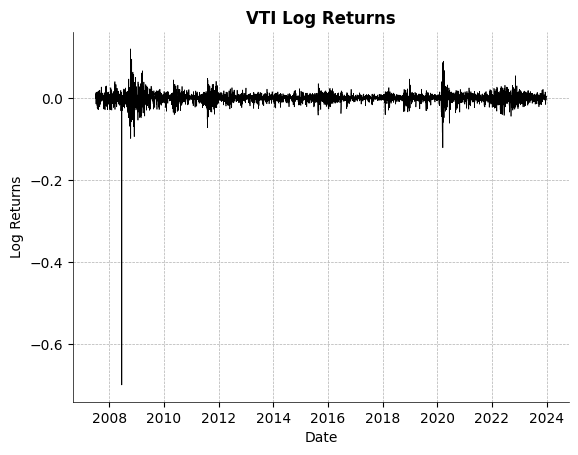

In [15]:
# Plot log-returns for VTI.
fig, ax = plt.subplots()
ax.plot(stocks['DATE'], stocks['LOG_RETS'], color='black', linewidth=0.5)
ax.set_title('VTI Log Returns', fontsize=12, fontweight='bold', loc='center')
ax.set_ylabel('Log Returns', fontsize=10)
ax.set_xlabel('Date', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

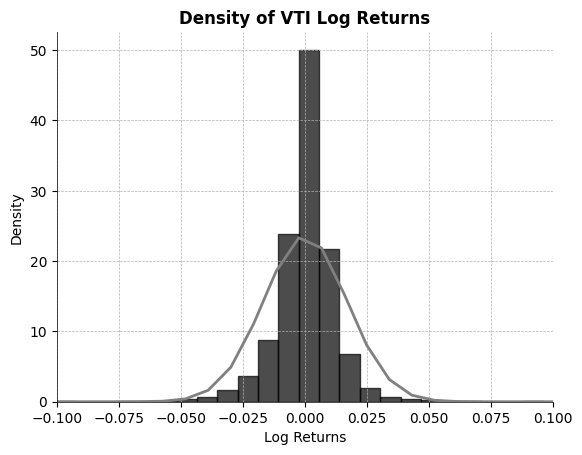

In [16]:
# Plot histogram of log-returns for VTI.
fig, ax = plt.subplots()
ax.hist(stocks['LOG_RETS'], bins=100, density=True, color='black', edgecolor='black', alpha=0.7, label='Log Returns')
mean = np.mean(stocks['LOG_RETS'])
std_dev = np.std(stocks['LOG_RETS'])
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
y = 1/(std_dev * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * std_dev**2))
ax.plot(x, y, color='grey', linewidth=2, label='Standard Normal Curve')
ax.set_title('Density of VTI Log Returns', fontsize=12, fontweight='bold', loc='center')
ax.set_xlabel('Log Returns', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.set_xlim(-0.1, 0.1)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

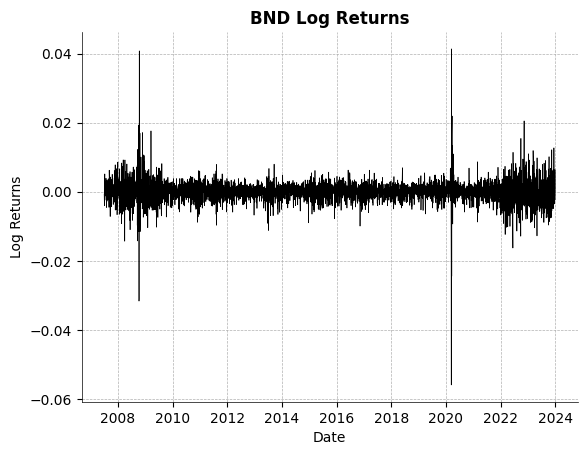

In [16]:
# Plot log-returns for BND.
fig, ax = plt.subplots()
ax.plot(bonds['DATE'], bonds['LOG_RETS'], color='black', linewidth=0.5)
ax.set_title('BND Log Returns', fontsize=12, fontweight='bold', loc='center')
ax.set_ylabel('Log Returns', fontsize=10)
ax.set_xlabel('Date', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

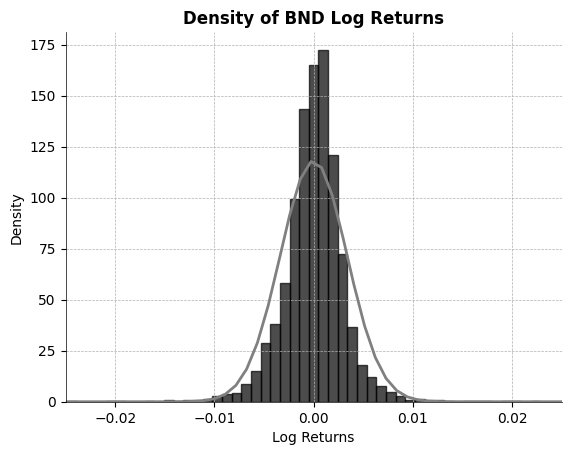

In [17]:
# Plot histogram of log-returns for VTI.
fig, ax = plt.subplots()
ax.hist(bonds['LOG_RETS'], bins=100, density=True, color='black', edgecolor='black', alpha=0.7, label='Log Returns')
mean = np.mean(bonds['LOG_RETS'])
std_dev = np.std(bonds['LOG_RETS'])
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
y = 1/(std_dev * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * std_dev**2))
ax.plot(x, y, color='grey', linewidth=2, label='Standard Normal Curve')
ax.set_title('Density of BND Log Returns', fontsize=12, fontweight='bold', loc='center')
ax.set_xlabel('Log Returns', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.set_xlim(-0.025, 0.025)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

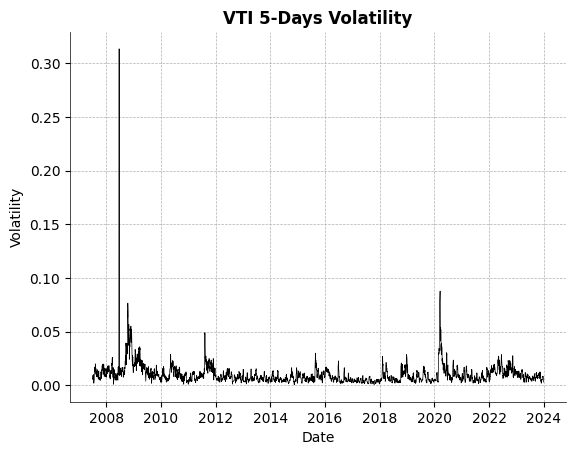

In [17]:
# Plot volatility for VTI.
fig, ax = plt.subplots()
ax.plot(stocks['DATE'], stocks['VOL_5DAY'], color='black', linewidth=0.5)
ax.set_title('VTI 5-Days Volatility', fontsize=12, fontweight='bold', loc='center')
ax.set_ylabel('Volatility', fontsize=10)
ax.set_xlabel('Date', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

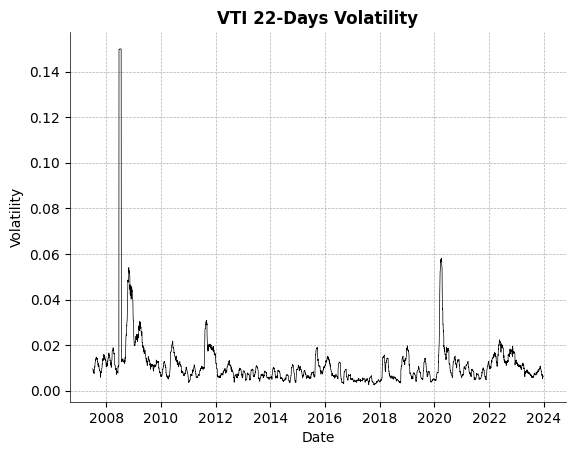

In [18]:
# Plot volatility for VTI.
fig, ax = plt.subplots()
ax.plot(stocks['DATE'], stocks['VOL_22DAY'], color='black', linewidth=0.5)
ax.set_title('VTI 22-Days Volatility', fontsize=12, fontweight='bold', loc='center')
ax.set_ylabel('Volatility', fontsize=10)
ax.set_xlabel('Date', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

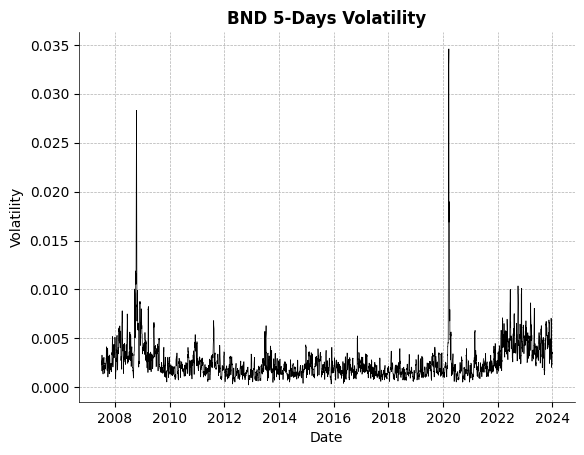

In [19]:
# Plot volatility for BND.
fig, ax = plt.subplots()
ax.plot(bonds['DATE'], bonds['VOL_5DAY'], color='black', linewidth=0.5)
ax.set_title('BND 5-Days Volatility', fontsize=12, fontweight='bold', loc='center')
ax.set_ylabel('Volatility', fontsize=10)
ax.set_xlabel('Date', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

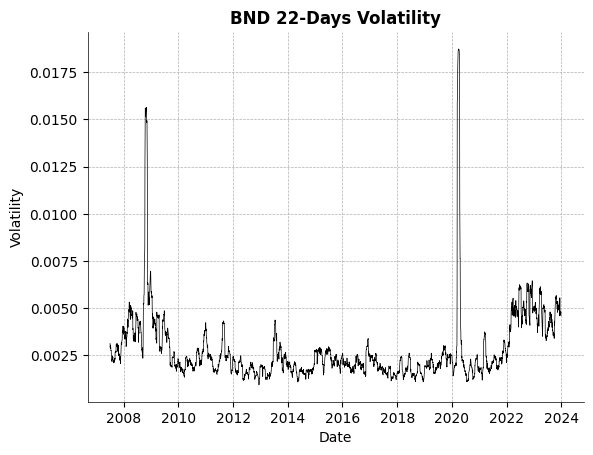

In [20]:
# Plot volatility for BND.
fig, ax = plt.subplots()
ax.plot(bonds['DATE'], bonds['VOL_22DAY'], color='black', linewidth=0.5)
ax.set_title('BND 22-Days Volatility', fontsize=12, fontweight='bold', loc='center')
ax.set_ylabel('Volatility', fontsize=10)
ax.set_xlabel('Date', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig("bnd_22days_volatility.png")
plt.show()

<H4>Get summary statistics</H4>

In [21]:
# Get the summary statistics for the columns of interest (VTI).
stocks.loc[:, ['LOG_RETS', 'VOL_5DAY', 'VOL_22DAY', 'IVOL']].describe()

,LOG_RETS,VOL_5DAY,VOL_22DAY,IVOL
count,4154.000000,4154.000000,4154.000000,4154.000000
mean,0.000111,0.010566,0.011477,1.104189
std,0.016920,0.013216,0.012436,0.520662
min,-0.700527,0.000446,0.002565,0.000000
25%,-0.004496,0.005260,0.006359,0.754875
50%,0.000714,0.008199,0.008838,0.967626
75%,0.006177,0.012700,0.012752,1.317125
max,0.120710,0.313407,0.149914,4.637659


In [22]:
# Get the summary statistics for the columns of interest (BND).
bonds.loc[:, ['LOG_RETS', 'VOL_5DAY', 'VOL_22DAY', 'IVOL']].describe()

,LOG_RETS,VOL_5DAY,VOL_22DAY,IVOL
count,4154.000000,4154.000000,4154.000000,4154.000000
mean,-0.000002,0.002637,0.002790,0.327376
std,0.003379,0.002110,0.001898,0.230303
min,-0.055920,0.000247,0.000941,0.000000
25%,-0.001541,0.001541,0.001794,0.217852
50%,0.000123,0.002142,0.002229,0.264752
75%,0.001663,0.003133,0.003176,0.359081
max,0.041335,0.034580,0.018730,2.851062


<H4>Preparing the training, testing, and validation sets.</H4>

In [7]:
# Define the size of training, testing, and validaiton sets following the general advice of an 80/20 split.
# The split is adjusted so that the testing set consists of an integer divisible by 20 after missing values 
# generated during forecasts are removed.
TRAIN_SIZE = int(round(len(stocks) * 0.80, 0) - 10)
TEST_SIZE  = int(round(len(stocks) * 0.20, 0) + 10)

# Check if all available data is used.
TRAIN_SIZE + TEST_SIZE == len(stocks)

True

In [8]:
# Replace missing implied volatility values with the median of the test set.

# Replace zeros with NaN so that the zeros do not influence the median.
for df in [stocks, bonds]:
    for col in df.columns:
        if 'IVOL' in col:
            df[col] = df[col].apply(lambda x: np.NaN if x == 0 else x)

# Compute the medians. Tavoid data leakage through the median, it will be computed only on the training set.
bonds_median_lstm  = bonds.loc[:2472 - 1, 'IVOL'].median()
stocks_median_lstm = stocks.loc[:2472 - 1, 'IVOL'].median()

# Imput the median into the missing values.
for col in stocks.columns:
    if 'IVOL' in col:
        stocks[col] = stocks[col].fillna(stocks_median_lstm)
for col in bonds.columns:
    if 'IVOL' in col:
        bonds[col] = bonds[col].fillna(bonds_median_lstm)

<h4> Lopez (1999) Loss Function </h4>

In [9]:
# Define the loss function based on Lopez (1999).
def lopez_loss(row):
    epsilon = row['LOG_RETS']
    var = row['VaR']
    if epsilon < var:
        return 1 + (epsilon - var) ** 2
    else:
        return 0

<H4>Caporin (2008) Loss Function</h4>

In [10]:
#Define the loss function based on Caporin (2008).
def caporin_loss(row):
    epsilon = row['LOG_RETS']
    var = row['VaR']

    return np.abs(epsilon - var)

<H4>The Historical Average Approach.</H4>

In [11]:
def HIS_VAR(df):
    # Generate a copy of the input dataset.
    df = df.copy()
    # Generate prediction.    
    df['PREDICTED_VOL'] = df['VOL_22DAY'].shift(1)
    # Define the critical value following RiskMetrics (1996).
    q = -1.65
    # Generate VaR.
    VaR = pd.DataFrame(df['PREDICTED_VOL']* q).rename(columns={'PREDICTED_VOL': 'VaR'})
    # Combine the VaR data with the main dataset.
    df = pd.concat([df, VaR], axis = 1)
    # Filter the data to only contain the testing set.
    df = df.loc[TRAIN_SIZE + 1:, :]
    # Spot VaR violations.
    df['VaR Violation'] = df['LOG_RETS'] < df['VaR']
    # Return the final dataset and the MSE.
    return df, mean_squared_error(df['VOL_5DAY'], df['PREDICTED_VOL'])

In [12]:
# Results for stocks.
his_stocks, his_mse_stocks = HIS_VAR(stocks)
his_stocks_violation = his_stocks['VaR Violation'].value_counts()[1]
print(f'HISTORICAL AVERAGE - STOCKS')
print(f'MSE: {his_mse_stocks}.')
print(f'Violations: {his_stocks_violation}.')
print(f'Lopez Loss: {his_stocks.apply(lopez_loss, axis = 1).sum()}')
print(f'Caporin Loss: {his_stocks.apply(caporin_loss, axis = 1).sum()}')

HISTORICAL AVERAGE - STOCKS
MSE: 1.312517208679176e-05.
Violations: 51.
Lopez Loss: 51.003761170332794
Caporin Loss: 15.892772052248237


In [13]:
# Results for bonds
his_bonds, his_mse_bonds = HIS_VAR(bonds)
his_bonds_violation = his_bonds['VaR Violation'].value_counts()[1]
print(f'GARCH - BONDS')
print(f'MSE: {his_mse_bonds}.')
print(f'Violations: {his_bonds_violation}.')
print(f'Lopez Loss: {his_bonds.apply(lopez_loss, axis = 1).sum()}')
print(f'Caporin Loss: {his_bonds.apply(caporin_loss, axis = 1).sum()}')

GARCH - BONDS
MSE: 1.5117136891660414e-06.
Violations: 53.
Lopez Loss: 53.00039976743343
Caporin Loss: 5.161080561863402


<H4>The GARCH model.</H4>

In [14]:
def GARCH(df, p=1, q=1):
    # Generate a copy of the input dataset.
    df = df.copy()
    # Define the model's specification.
    garch_model = arch_model(df['LOG_RETS'], vol="Garch", mean='Zero', p=p, q=q, dist='normal', rescale=False)
    # Compute the model's parameters based on the training data. 
    garch_results = garch_model.fit(disp="off", last_obs = TRAIN_SIZE)
    # Generate one-step-ahead forecasts using the data that was not used in training.
    garch_forecasts = garch_results.forecast(start = TRAIN_SIZE, align="target", horizon=1)
    # Get values for the variance.
    forecasted_var  = (garch_forecasts.variance)
    # Compute the volatility based on the variance.
    forecasted_vol  = np.sqrt(forecasted_var).dropna()
    # Combine forecasts with actual values.
    df = pd.concat([df.loc[TRAIN_SIZE + 1:, :], forecasted_vol], axis = 1).reset_index(drop = True).rename(columns = {'h.1' : 'PREDICTED_VOL'})
    # Define the critical value following RiskMetrics (1996).
    q = -1.65
    # Generate VaR.
    df['VaR'] = q * df['PREDICTED_VOL']
    # Spot VaR violations.
    df['VaR Violation'] = df['LOG_RETS'] < df['VaR']
    # Return the final dataset and the MSE.
    return df, mean_squared_error(df['VOL_5DAY'], df['PREDICTED_VOL'])

In [15]:
# Results for stocks.
garch_stocks, garch_mse_stocks = GARCH(stocks)
garch_stocks_violation = garch_stocks['VaR Violation'].value_counts()[1]
print(f'GARCH - STOCKS')
print(f'MSE: {garch_mse_stocks}.')
print(f'Violations: {garch_stocks_violation}.')
print(f'Lopez Loss: {garch_stocks.apply(lopez_loss, axis = 1).sum()}')
print(f'Caporin Loss: {garch_stocks.apply(caporin_loss, axis = 1).sum()}')

GARCH - STOCKS
MSE: 1.3474706221915024e-05.
Violations: 34.
Lopez Loss: 34.001960682816545
Caporin Loss: 17.93012036697965


In [16]:
# Results for bonds
garch_bonds, garch_mse_bonds = GARCH(bonds)
garch_bonds_violation = garch_bonds['VaR Violation'].value_counts()[1]
print(f'GARCH - BONDS')
print(f'MSE: {garch_mse_bonds}.')
print(f'Violations: {garch_bonds_violation}.')
print(f'Lopez Loss: {garch_bonds.apply(lopez_loss, axis = 1).sum()}')
print(f'Caporin Loss: {garch_bonds.apply(caporin_loss, axis = 1).sum()}')

GARCH - BONDS
MSE: 9.808879579964191e-07.
Violations: 52.
Lopez Loss: 52.00039913014592
Caporin Loss: 5.111020221341857


/Users/filipborzecki/miniforge3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<H4>The SVR-GARCH model.</H4>

In [17]:
def SVR_GARCH(df, kernel='linear'):
    # Generate a copy of the input dataset.
    df = df.copy()
    # Each prediction for t+1 is based on values for t - shift so that target from t+1 is aligned with data from t.
    df['LABEL'] = df['VARIANCE'].shift(-1)

    #Initialize the model.
    model      = SVR(kernel=kernel)

    # Set the grid of parameters for both types of kernels.
    # Return an error if a kernel is not supported
    if kernel == 'linear':
        param_distributions = {
            'C': sp_rand(), 
            'epsilon': sp_rand(), 
            'kernel': [kernel]}
    elif kernel == 'rbf':
        param_distributions = {
            'gamma': sp_rand(),  
            'C': sp_rand(),  
            'epsilon': sp_rand(),  
            'kernel': [kernel]}
    else:
        raise ValueError('Unsupported kernel.')

    # Find the paramters of the model using the Randomized Search method with 5-fold cross-validation,
    clf = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=5, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, random_state = 42)

    # Create training and testing sets.
    X_train = df.loc[:TRAIN_SIZE - 1, ['LOG_RETS_SQ', 'VARIANCE']].values
    Y_train = df.loc[:TRAIN_SIZE - 1, ['LABEL']].values

    # Scale the sets.
    scale_X = StandardScaler()
    scale_Y = StandardScaler()
    X = scale_X.fit_transform(X_train)
    Y = scale_Y.fit_transform(Y_train)

    # Fit the model to the training data.
    clf.fit(X, Y.ravel())

    # Create a testing set to evaluate the MAE. The set starts from TRAIN_SIZE since the training data ended on TRAIN_SIZE - 1.
    X_test = df.loc[TRAIN_SIZE:, ['LOG_RETS_SQ', 'VARIANCE']].values

    # Scale the testing set using the parameters computed during scaling of the training set.
    # This is done to avoid data leakage (i.e. parameters are based also on values that should not be seen yet by the model).
    X_test = scale_X.transform(X_test)

    # Generate predictions.
    predictions = clf.predict(X_test)
    
    # Rescale the predictions back to their original ranges. Reshape the predicitons to an array of a single column.
    predictions = scale_Y.inverse_transform(predictions.reshape(-1,1))

    # Shift the predictions one step to the future so that forecasts are aligned with actual observations.
    # Drop the one missing value that was generated at the beginning of the set (there is no prediciton for t=0).
    predictions = pd.DataFrame(predictions).shift(1).rename(columns={0:'PREDICTED_VARIANCE'})

    # Combine predictions with actual values.
    df = pd.concat([df.loc[TRAIN_SIZE:, :].reset_index(), predictions.reset_index()], axis=1)

    # Drop redundant columns.
    df.drop(columns = ['LABEL', 'index'], inplace = True)
    
    # Drop the missing value (no predictions is made at t=0).
    df = df.dropna().reset_index(drop = True)

    # Define the critical value following RiskMetrics (1996).
    q = -1.65

    # Generate VaR.
    var = np.sqrt(df['PREDICTED_VARIANCE']) * q
    df['VaR'] = var

    # Spot VaR violations.
    df['VaR Violation'] = df['LOG_RETS'] < df['VaR']

    # Return the final dataset and the MSE.
    return df, mean_squared_error(df['VOL_5DAY'], np.sqrt(df['PREDICTED_VARIANCE'])), clf.best_params_

In [18]:
# Results for stocks, using linear kernel.
svr_stocks_linear, svr_stocks_linear_mse, params_linear_stocks = SVR_GARCH(stocks, kernel = 'linear')
svr_stocks_linear_violation = svr_stocks_linear['VaR Violation'].value_counts()[1]
print(f'SVR - STOCKS - LINEAR KERNEL')
print(f'MSE: {svr_stocks_linear_mse}.')
print(f'Violations: {svr_stocks_linear_violation}.')
print(f'Lopez Loss: {svr_stocks_linear.apply(lopez_loss, axis = 1).sum()}')
print(f'Caporin Loss: {svr_stocks_linear.apply(caporin_loss, axis = 1).sum()}')

SVR - STOCKS - LINEAR KERNEL
MSE: 8.07351317748103e-06.
Violations: 36.
Lopez Loss: 36.00230661214205
Caporin Loss: 17.487677604518893


In [19]:
# Results for stocks, using RBF kernel.
svr_stocks_rbf, svr_stocks_rbf_mse, params_rbf_stocks = SVR_GARCH(stocks, kernel = 'rbf')
svr_stocks_rbf_violation = svr_stocks_rbf['VaR Violation'].value_counts()[1]
print(f'SVR - STOCKS - RBF KERNEL')
print(f'MSE: {svr_stocks_rbf_mse}.')
print(f'Violations: {svr_stocks_rbf_violation}.')
print(f'Lopez Loss: {svr_stocks_rbf.apply(lopez_loss, axis = 1).sum()}')
print(f'Caporin Loss: {svr_stocks_rbf.apply(caporin_loss, axis = 1).sum()}')

SVR - STOCKS - RBF KERNEL
MSE: 9.120189949518978e-06.
Violations: 38.
Lopez Loss: 38.002436561869644
Caporin Loss: 17.214953978066635


In [20]:
# Results for bonds, using linear kernel.
svr_bonds_linear, svr_bonds_linear_mse, params_linear_bonds = SVR_GARCH(bonds, kernel = 'linear')
svr_bonds_linear_violation = svr_bonds_linear['VaR Violation'].value_counts()[1]
print(f'SVR - BONDS - LINEAR KERNEL')
print(f'MSE: {svr_bonds_linear_mse}.')
print(f'Violations: {svr_bonds_linear_violation}.')
print(f'Lopez Loss: {svr_bonds_linear.apply(lopez_loss, axis = 1).sum()}')
print(f'Caporin Loss: {svr_bonds_linear.apply(caporin_loss, axis = 1).sum()}')

SVR - BONDS - LINEAR KERNEL
MSE: 6.744046387764332e-07.
Violations: 63.
Lopez Loss: 63.00045489247307
Caporin Loss: 5.216640298560848


In [21]:
# Results for bonds, using RBF kernel.
svr_bonds_rbf, svr_bonds_rbf_mse, params_rbf_bonds = SVR_GARCH(bonds, kernel = 'rbf')
svr_bonds_rbf_violation = svr_bonds_rbf['VaR Violation'].value_counts()[1]
print(f'SVR - BONDS - RBF KERNEL')
print(f'MSE: {svr_bonds_rbf_mse}.')
print(f'Violations: {svr_bonds_rbf_violation}.')
print(f'Lopez Loss: {svr_bonds_rbf.apply(lopez_loss, axis = 1).sum()}')
print(f'Caporin Loss: {svr_bonds_rbf.apply(caporin_loss, axis = 1).sum()}')

SVR - BONDS - RBF KERNEL
MSE: 1.5720957496089907e-06.
Violations: 45.
Lopez Loss: 45.00032687433421
Caporin Loss: 5.77378936624688


<H4>The LSTM model.</H4>

In [11]:
# For LSTM, on top of training and tesitng sets, a validation set is also needed. To keep the testing set of the same size in all of the models,
# some of the data previously used for training will now be used for validaiton - a 60/20/20 split will be used. 
TRAIN_SIZE_LSTM = TRAIN_SIZE - TEST_SIZE
VALID_SIZE_LSTM = TEST_SIZE
TRAIN_SIZE_LSTM + VALID_SIZE_LSTM + TEST_SIZE == len(stocks)

True

In [12]:
# Define a function that will prepare the data.
def prepare_data(df, ivol, lags):
    # Generate a copy of the input dataset.
    df = df.copy()

    # Delete the columns, depending on the choice of the feature set.
    if ivol:
        df = df.drop(columns = ['PRICE', 'BID', 'ASK', 'VOLUME', 'LOG_RETS',])
        for col in df.columns:
            if 'VARIANCE' in col:
                df = df.drop(columns = col)
    else:
        df = df.drop(columns = ['PRICE', 'BID', 'ASK', 'VOLUME', 'LOG_RETS'])
        for col in df.columns:
            if 'VARIANCE' in col:
                df = df.drop(columns = col)
        for col in df.columns:
            if 'IVOL' in col:
                df = df.drop(columns = col)

    # Create a target column for forecasting, which is the observed value from the next day.
    df['NEXT_DAY_VOL'] = df['VOL_5DAY'].shift(-1)

    # Divide the data into X and Y sets, and store the dates in a different array.
    dates = df['DATE'].values
    X = df.drop(columns = ['NEXT_DAY_VOL', 'DATE']).values
    Y = df['NEXT_DAY_VOL'].values

    # Split the data into sets.
    dates_train, X_train, Y_train = dates[:TRAIN_SIZE_LSTM], X[:TRAIN_SIZE_LSTM], Y[:TRAIN_SIZE_LSTM]
    dates_val, X_val, Y_val       = dates[TRAIN_SIZE_LSTM:TRAIN_SIZE_LSTM+VALID_SIZE_LSTM], X[TRAIN_SIZE_LSTM:TRAIN_SIZE_LSTM+VALID_SIZE_LSTM], Y[TRAIN_SIZE_LSTM:TRAIN_SIZE_LSTM+VALID_SIZE_LSTM]
    dates_test, X_test, Y_test    = dates[TRAIN_SIZE_LSTM+VALID_SIZE_LSTM:], X[TRAIN_SIZE_LSTM+VALID_SIZE_LSTM:], Y[TRAIN_SIZE_LSTM+VALID_SIZE_LSTM:]

    # Initialize the scalers.
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    
    # Scale the data.
    X_train_scaled = scaler_X.fit_transform(X_train)
    Y_train_scaled = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
    X_val_scaled   = scaler_X.transform(X_val)
    Y_val_scaled   = scaler_Y.transform(Y_val.reshape(-1, 1))
    X_test_scaled  = scaler_X.transform(X_test)

    # Reshape the scaled data for LSTM.
    timesteps = lags + 1  
    if ivol:
        num_features = 4
    else:
        num_features = 3

    # Reshape for LSTM input: [samples, timesteps, features]
    X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, num_features))
    X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, num_features))
    X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], timesteps, num_features))

    # Return a dictionary with the final set of features.
    return {'X_TRAIN' : X_train_reshaped, 'Y_TRAIN' : Y_train_scaled, 'X_VALIDATE' : X_val_reshaped, 'Y_VALIDATE' : Y_val_scaled, 'X_TEST' : X_test_reshaped, 'TRAIN_DATES' : dates_train, 'VALIDATE_DATES' : dates_val, 'TEST_DATES' : dates_test}, scaler_Y




In [13]:
# Define the function that returns the results of a model with a given specification.
def lstm_model(df, data, scaler, n1 = 512, n2 = 512, activation = 'tanh', learning_rate = 0.001, dropout = 0, weight_decay = 0.001, epochs = 10, batch_size = 16):
    
    # Clear the session to improve reproducability.
    tf.keras.backend.clear_session(free_memory=True)
    
    # Generate a copy of the input dataset.
    df = df.copy()
    
    # Initialize the model.
    model = Sequential()

    # Add the first LSTM layer.
    model.add(layers.LSTM(n1, activation = activation, input_shape = (data['X_TRAIN'].shape[1], data['X_TRAIN'].shape[2]), return_sequences = True, kernel_regularizer = l2(weight_decay)))

    # Add the second LSTM layer.
    model.add(layers.LSTM(n2, activation = activation, return_sequences = False, kernel_regularizer = l2(weight_decay)))

    # Add a Dropout layer.
    model.add(layers.Dropout(dropout))

    # Add a Dense layer.
    model.add(layers.Dense(data['Y_TRAIN'].shape[1], kernel_regularizer = l2(weight_decay)))

    # Compile the model.
    model.compile(loss = 'mse', optimizer = Adam(learning_rate = learning_rate), metrics = ['mean_absolute_error'])

    # Train and validate the model.
    history = model.fit(data['X_TRAIN'], data['Y_TRAIN'], validation_data = (data['X_VALIDATE'], data['Y_VALIDATE']), epochs = epochs, batch_size = batch_size, verbose = 0)

    # Make  and rescale predictions.
    predictions_scaled = model.predict(data['X_TEST'])
    predictions_test = scaler.inverse_transform(predictions_scaled)
    
    # Align predictions with the actual values.
    predictions_test = pd.DataFrame(predictions_test).rename(columns={0:'PREDICTED_VOL'}).shift(1)

    # Filter the input dataset and add predictions.
    df = df.loc[TRAIN_SIZE_LSTM+VALID_SIZE_LSTM:, :].reset_index(drop = True)
    df = pd.concat([df, predictions_test], axis = 1).dropna().reset_index(drop = True)

    # Define the critical value following RiskMetrics (1996).
    q = -1.65

    # Generate VaR.
    df['VaR'] = df['PREDICTED_VOL'] * q

    # Spot VaR violations.
    df['VaR Violation'] = df['LOG_RETS'] < df['VaR']

    # Get MSE and the number of violations.
    mse = mean_squared_error(df['VOL_5DAY'], df['PREDICTED_VOL'])
    violations = df['VaR Violation'].value_counts()[1]

    return df, mse, violations


<H4>VTI</H4>

In [14]:
# Results for stocks without implied volatility.

data = prepare_data(stocks, False, LAGS)[0]
scaler = prepare_data(stocks, False, LAGS)[1]

stocks_lstm, mse_stocks_lstm, violations_stocks_lstm = lstm_model(stocks, data, scaler, n1 = 512, n2 = 512, activation = 'tanh', learning_rate = 0.001, dropout = 0.6, weight_decay = 0.001, epochs = 10, batch_size = 16)

print(f'LSTM - STOCKS')
print(f'MAE: {mse_stocks_lstm}. Violations: {violations_stocks_lstm}.')
print(f'Lopez Loss: {stocks_lstm.apply(lopez_loss, axis = 1).sum()}')
print(f'Caporin Loss: {stocks_lstm.apply(caporin_loss, axis = 1).sum()}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
LSTM - STOCKS
MAE: 8.427385977619574e-06. Violations: 74.
Lopez Loss: 74.00462187451856
Caporin Loss: 16.223124199673215


In [14]:
# Results for stocks with implied volatility.

data = prepare_data(stocks, True, LAGS)[0]
scaler = prepare_data(stocks, True, LAGS)[1]

stocks_lstm, mse_stocks_lstm, violations_stocks_lstm = lstm_model(stocks, data, scaler, n1 = 512, n2 = 512, activation = 'tanh', learning_rate = 0.001, dropout = 0.6, weight_decay = 0.001, epochs = 10, batch_size = 16)

print(f'LSTM - STOCKS')
print(f'MAE: {mse_stocks_lstm}. Violations: {violations_stocks_lstm}.')
print(f'Lopez Loss: {stocks_lstm.apply(lopez_loss, axis = 1).sum()}')
print(f'Caporin Loss: {stocks_lstm.apply(caporin_loss, axis = 1).sum()}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
LSTM - STOCKS
MAE: 5.19421805611101e-06. Violations: 47.
Lopez Loss: 47.0028936556499
Caporin Loss: 16.115606602822034


<H4>BND</H4>

In [18]:
# Results for bonds without implied volatility.

data = prepare_data(bonds, False, LAGS)[0]
scaler = prepare_data(bonds, False, LAGS)[1]

bonds_lstm, mse_bonds_lstm, violations_bonds_lstm = lstm_model(bonds, data, scaler, n1 = 512, n2 = 512, activation = 'tanh', learning_rate = 0.001, dropout = 0.7, weight_decay = 0.001, epochs = 10, batch_size = 16)

print(f'LSTM - BONDS')
print(f'MAE: {mse_bonds_lstm}. Violations: {violations_bonds_lstm}.')
print(f'Lopez Loss: {bonds_lstm.apply(lopez_loss, axis = 1).sum()}')
print(f'Caporin Loss: {bonds_lstm.apply(caporin_loss, axis = 1).sum()}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
LSTM - STOCKS
MAE: 4.5414735271677225e-07. Violations: 69.
Lopez Loss: 69.00047759506731
Caporin Loss: 5.052014374576665


In [14]:
# Results for bonds with implied volatility.

data = prepare_data(bonds, True, LAGS)[0]
scaler = prepare_data(bonds, True, LAGS)[1]

bonds_lstm, mse_bonds_lstm, violations_bonds_lstm = lstm_model(bonds, data, scaler, n1 = 512, n2 = 512, activation = 'tanh', learning_rate = 0.001, dropout = 0.7, weight_decay = 0.001, epochs = 10, batch_size = 16)

print(f'LSTM - BONDS')
print(f'MAE: {mse_bonds_lstm}. Violations: {violations_bonds_lstm}.')
print(f'Lopez Loss: {bonds_lstm.apply(lopez_loss, axis = 1).sum()}')
print(f'Caporin Loss: {bonds_lstm.apply(caporin_loss, axis = 1).sum()}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
LSTM - STOCKS
MAE: 5.233418524147563e-07. Violations: 67.
Lopez Loss: 67.000429960014
Caporin Loss: 5.2967708813734875
